# SIames model evaluateion

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from tqdm import tqdm
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import glob
from collections import defaultdict
import pandas as pd
import gc
import json
import matplotlib.pyplot as plt
from siamese_dataset2 import SiameseDataset
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from pathlib import Path
from test_model import evaluate, loss_graf, predict
from siamese_dataset2 import SiameseDataset


In [2]:
device = torch.device("cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
print(f"Device: {device}")


Device: mps


## INIT THE MODEL

In [3]:
class SiameseNetwork(nn.Module):
    def __init__(self, base_model):
        super(SiameseNetwork, self).__init__()
        self.base_model = base_model
        self.classifier = nn.Linear(1280, 1)

    def forward(self, input1, input2):
        output1 = self.base_model(input1)
        output2 = self.base_model(input2)
        l1_distance = torch.abs(output1 - output2)
        output = self.classifier(l1_distance)
        return output




### Load Weights

In [4]:
model_path='/Users/aljazjustin/Siht/Praksa/compear_model/models/best_model_loss.pth'
checkpoint = torch.load(model_path, map_location=torch.device('cpu'))


# Load state_dict into classifier
model_base = efficientnet_b0()
model_base.classifier = nn.Identity()
model_base.load_state_dict(checkpoint['model_state_dict'])
model_base.eval()
model= SiameseNetwork(model_base)
# print(model)

model.classifier.load_state_dict(checkpoint['linear_state_dict'])
model.to(device)
_=model.eval()

### Prepear test dataset

In [5]:
def convert_to_rgb(image):
    return image.convert('RGB')



transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(convert_to_rgb),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_files="/Users/aljazjustin/Siht/Praksa/NEW/final_data/test"

dataset_test = SiameseDataset(test_files, transform=transform)
test_loader = DataLoader(dataset_test, batch_size=16, shuffle=False, pin_memory=True)  # Use pinned memory

In [6]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

model.eval()
predictions = []
labels = []

def evaluate_model(model, test_loader, threshold=0.5):
    for batch in test_loader:
        image1, image2, label = batch
        image1 = image1.to(device)
        image2 = image2.to(device)
        output = model(image1, image2)
        
        # Convert model output to label
        predicted_labels = (output > threshold).float()
        predictions.extend(predicted_labels.tolist())
        labels.extend(label.tolist())

    # Calculate precision and recall
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    return precision, recall, accuracy, f1

precision, recall, accuracy, f1 = evaluate_model(model, test_loader)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')


Precision: 0.5932864949258392
Recall: 0.9429280397022333
Accuracy: 0.6604790419161677
F1 Score: 0.7283181600383325


### Find the best threshold for the model

In [8]:
# find the best threshold for the model 
thresholds = {}
for i in range(34,84, 2):
    i=i/100
    precision, recall, accuracy, f1 = [], [], [], []
    
    for _ in range(5):
        precision_, recall_, accuracy_, f1_ = evaluate_model(model, test_loader, threshold=i)
        precision.append(precision_)
        recall.append(recall_)
        accuracy.append(accuracy_)
        f1.append(f1_)
    print(f'Threshold: {i},Accuracy: {np.mean(accuracy)}')    
    thresholds[i] = {'precision': np.mean(precision), 'recall': np.mean(recall), 'accuracy': np.mean(accuracy), 'f1': np.mean(f1)}

print(thresholds)
    


Threshold: 0.34,Accuracy: 0.6633494487038245
Threshold: 0.36,Accuracy: 0.6623152838775411
Threshold: 0.38,Accuracy: 0.6636836008465125
Threshold: 0.4,Accuracy: 0.6639407057108258
Threshold: 0.42,Accuracy: 0.664437322897587
Threshold: 0.44,Accuracy: 0.666190228797095
Threshold: 0.46,Accuracy: 0.6665904890422395
Threshold: 0.48,Accuracy: 0.6669510496763167
Threshold: 0.5,Accuracy: 0.6669000332231241
Threshold: 0.52,Accuracy: 0.6673864515831258
Threshold: 0.54,Accuracy: 0.668241341767945
Threshold: 0.56,Accuracy: 0.6686000955212437
Threshold: 0.58,Accuracy: 0.6694603610151477
Threshold: 0.6,Accuracy: 0.6700547141443371
Threshold: 0.62,Accuracy: 0.6709995364274465
Threshold: 0.64,Accuracy: 0.6717722791300088
Threshold: 0.66,Accuracy: 0.6723096664381327
Threshold: 0.68,Accuracy: 0.6726047118286005
Threshold: 0.7,Accuracy: 0.6733091801425033
Threshold: 0.72,Accuracy: 0.6740555280795334
Threshold: 0.74,Accuracy: 0.674807955001654
Threshold: 0.76,Accuracy: 0.6753781521888131
Threshold: 0.78,Ac

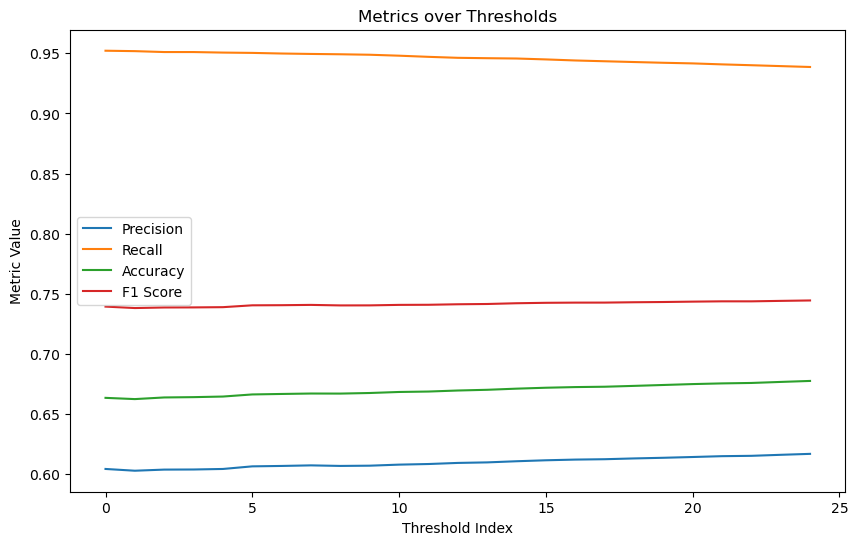

In [9]:
import matplotlib.pyplot as plt

# separate the values
precision = [thresholds[x]['precision'] for x in thresholds]
recall = [thresholds[x]['recall'] for x in thresholds]
accuracy = [thresholds[x]['accuracy'] for x in thresholds]
f1 = [thresholds[x]['f1'] for x in thresholds]

# plot the values
plt.figure(figsize=(10, 6))
plt.plot(precision, label='Precision')
plt.plot(recall, label='Recall')
plt.plot(accuracy, label='Accuracy')
plt.plot(f1, label='F1 Score')
plt.title('Metrics over Thresholds')
plt.xlabel('Threshold Index')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

In [10]:
max_acc = max_f1 = -1
best_threshold_acc=best_threshold_fi = None
for threshold in thresholds:

    if thresholds[threshold]['accuracy'] > max_acc :
        max_acc = thresholds[threshold]['accuracy']
        
        best_threshold_acc = threshold

    if thresholds[threshold]['f1'] > max_f1:
        max_f1 = thresholds[threshold]['f1']
        best_threshold_fi = threshold

print(f"Best threshold f1: {best_threshold_fi}, F1: {max_f1}")
print(f"Best threshold acc: {best_threshold_acc}, ACC: {max_acc}")

Best threshold f1: 0.82, F1: 0.7443920476542758
Best threshold acc: 0.82, ACC: 0.6774281710861673


In [11]:
# find the best threshold for the model 
thresholds = {}

precision, recall, accuracy, f1 = [], [], [], []
for _ in range(10):
    precision_, recall_, accuracy_, f1_ = evaluate_model(model, test_loader, threshold=best_threshold_acc)
    precision.append(precision_)
    recall.append(recall_)
    accuracy.append(accuracy_)
    f1.append(f1_)
print(f'Threshold: {best_threshold_acc}')
print(f'Precision: {np.mean(precision)}')
print(f'Recall: {np.mean(recall)}')
print(f'Accuracy: {np.mean(accuracy)}')
print(f'F1 Score: {np.mean(f1)}')

    


Threshold: 0.82
Precision: 0.6174880473091149
Recall: 0.9378207105137829
Accuracy: 0.6783246979345124
F1 Score: 0.744666258682421


In [14]:
# find the best threshold for the model 
thresholds = {}

precision, recall, accuracy, f1 = [], [], [], []
for _ in range(10):
    precision_, recall_, accuracy_, f1_ = evaluate_model(model, test_loader, threshold=0.9)
    precision.append(precision_)
    recall.append(recall_)
    accuracy.append(accuracy_)
    f1.append(f1_)
print(f'Threshold: {0.9}')
print(f'Precision: {np.mean(precision)}')
print(f'Recall: {np.mean(recall)}')
print(f'Accuracy: {np.mean(accuracy)}')
print(f'F1 Score: {np.mean(f1)}')

    


In [ ]:
# find the best threshold for the model 
thresholds = {}
for i in range(80,110, 2):
    i=i/100
    precision, recall, accuracy, f1 = [], [], [], []
    
    for _ in range(5):
        precision_, recall_, accuracy_, f1_ = evaluate_model(model, test_loader, threshold=i)
        precision.append(precision_)
        recall.append(recall_)
        accuracy.append(accuracy_)
        f1.append(f1_)
    print(f'Threshold: {i},Accuracy: {np.mean(accuracy)}')    
    thresholds[i] = {'precision': np.mean(precision), 'recall': np.mean(recall), 'accuracy': np.mean(accuracy), 'f1': np.mean(f1)}

print(thresholds)
    
